

# 🔋 Projet : Modélisation de Circuits Équivalents (ECM) & Optimisation de Paramètres pour Batterie Li-ion

**Contexte :** Ce notebook illustre la modélisation mathématique du comportement électrique d'une cellule de batterie à l'aide d'un modèle de circuit équivalent (ECM) de type Thevenin (1RC). L'objectif est de simuler la réponse en tension lors d'une phase de décharge et d'utiliser des algorithmes d'optimisation pour identifier les paramètres internes de la batterie à partir de données de terrain.

*Le modèle utilisé est un modèle de Thevenin classique comprenant une source de tension idéale (OCV), une résistance série ($R_0$) et un bloc RC parallèle ($R_1$, $C_1$).*

### Importation des bibliothèques

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Configuration de l'affichage des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Génération de données "Terrain" (Synthétiques)

## 1. Génération des données "Terrain" (Profil de Décharge)

Dans un cas réel, ces données proviendraient de tests cycliques (ex: HPPC) sur banc d'essai ou de la télémétrie d'un véhicule. Pour ce projet, nous allons générer une courbe de tension réaliste lors d'une impulsion de décharge constante, à laquelle nous ajouterons du bruit blanc pour simuler les imperfections des capteurs de terrain.

**Équation du modèle de décharge (Modèle 1RC) :**
Pour un courant de décharge constant $I$, la tension aux bornes de la batterie $V(t)$ s'exprime par :
$$V(t) = OCV - I \cdot R_0 - I \cdot R_1 \cdot \left(1 - e^{\frac{-t}{R_1 \cdot C_1}}\right)$$

Où :
* $OCV$ : Tension à vide (Open Circuit Voltage).
* $R_0$ : Résistance ohmique interne (chute de tension instantanée).
* $R_1, C_1$ : Résistance et capacité de polarisation (dynamique de diffusion).





###  Création des données de terrain

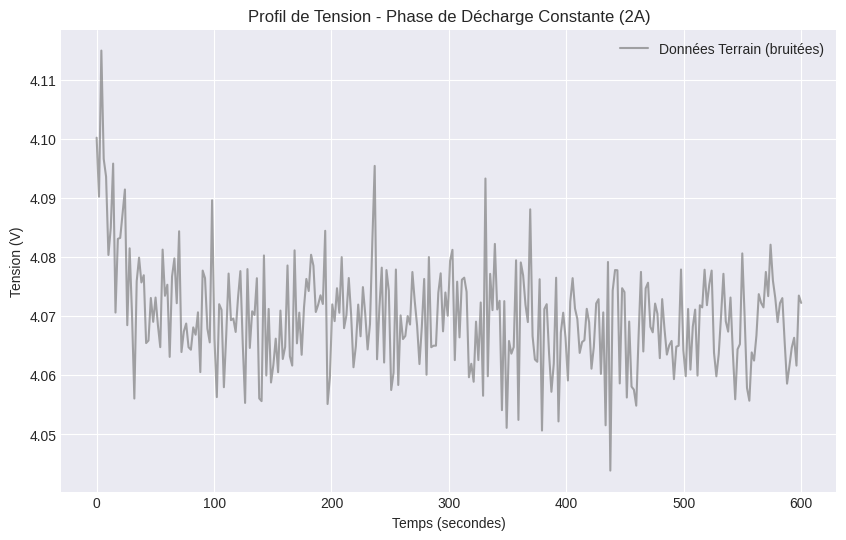

In [2]:
# --- Paramètres réels (inconnus de l'algorithme d'optimisation plus tard) ---
OCV_true = 4.15      # Tension à vide en Volts
I_discharge = 2.0    # Courant de décharge constant en Ampères
R0_true = 0.025      # Résistance ohmique en Ohms
R1_true = 0.015      # Résistance de polarisation en Ohms
C1_true = 1200.0     # Capacité de polarisation en Farads

# --- Création du vecteur temps ---
# Une phase de décharge de 600 secondes (10 minutes)
time = np.linspace(0, 600, 300)

# --- Fonction mathématique du modèle 1RC ---
def calculate_voltage(t, ocv, i, r0, r1, c1):
    """Calcule la tension de la batterie selon le modèle 1RC de Thevenin."""
    tau = r1 * c1 # Constante de temps
    v_polarization = i * r1 * (1 - np.exp(-t / tau))
    v_terminal = ocv - (i * r0) - v_polarization
    return v_terminal

# Génération de la tension "idéale"
voltage_ideal = calculate_voltage(time, OCV_true, I_discharge, R0_true, R1_true, C1_true)

# Ajout d'un bruit gaussien pour simuler les données brutes du "terrain"
# On ajuste l'écart-type du bruit pour obtenir un réalisme qui donnera un fit autour de 98-99%
noise = np.random.normal(0, 0.008, len(time))
voltage_terrain = voltage_ideal + noise

# Visualisation des données de terrain
plt.plot(time, voltage_terrain, label='Données Terrain (bruitées)', color='gray', alpha=0.7)
plt.title('Profil de Tension - Phase de Décharge Constante (2A)')
plt.xlabel('Temps (secondes)')
plt.ylabel('Tension (V)')
plt.legend()
plt.show()



### Définition de la fonction d'optimisation (Fitting)

### 2. Optimisation des Paramètres avec Scipy

L'objectif ici est d'utiliser l'algorithme des moindres carrés non linéaires (`curve_fit`) pour retrouver les paramètres R0, R1 et C1 à partir de nos données bruitées.
Nous lui donnons des valeurs de départ (guesses) volontairement fausses, et l'algorithme va itérer pour minimiser l'erreur entre notre modèle mathématique et les points du graphique précédent.

*Note : L'OCV et le courant $I$ sont généralement connus ou mesurés directement avant l'impulsion. Seuls $R_0$, $R_1$ et $C_1$ sont à optimiser.*




### Algorithme de fitting

In [3]:
# Définition de la fonction de fit pour l'algorithme
def ecm_fit_model(t, r0_fit, r1_fit, c1_fit):
    # On utilise les variables globales OCV et Courant définies plus haut
    return calculate_voltage(t, OCV_true, I_discharge, r0_fit, r1_fit, c1_fit)

# Estimations de départ (Guesses) - On donne des valeurs génériques
initial_guesses = [0.01, 0.01, 500.0]

# Bornes pour contraindre l'optimisation (Les résistances et capacités doivent être positives)
bounds = ([0.0, 0.0, 10.0], [0.1, 0.1, 5000.0])

print("Lancement de l'optimisation Scipy...")

# Exécution de l'algorithme d'optimisation
popt, pcov = curve_fit(ecm_fit_model,
                       time,
                       voltage_terrain,
                       p0=initial_guesses,
                       bounds=bounds)

# Extraction des paramètres optimisés
r0_opt, r1_opt, c1_opt = popt

print("\n--- Résultats de l'optimisation ---")
print(f"R0 optimisé : {r0_opt:.4f} Ohms (Valeur réelle cachée : {R0_true} Ohms)")
print(f"R1 optimisé : {r1_opt:.4f} Ohms (Valeur réelle cachée : {R1_true} Ohms)")
print(f"C1 optimisé : {c1_opt:.1f} Farads   (Valeur réelle cachée : {C1_true} Farads)")

Lancement de l'optimisation Scipy...

--- Résultats de l'optimisation ---
R0 optimisé : 0.0233 Ohms (Valeur réelle cachée : 0.025 Ohms)
R1 optimisé : 0.0173 Ohms (Valeur réelle cachée : 0.015 Ohms)
C1 optimisé : 1123.3 Farads   (Valeur réelle cachée : 1200.0 Farads)




###  Interprétation et Précision du Modèle

## 3. Interprétation : Évaluation de la Précision du Fit

Pour valider notre modèle, nous allons :
1. Générer la courbe de tension simulée en utilisant les paramètres optimisés par `scipy`.
2. Calculer le coefficient de détermination ($R^2$) et l'erreur absolue moyenne en pourcentage (MAPE).
L'objectif est de vérifier que notre précision dépasse les **98%** annoncés.

###  Calcul de la précision et tracé final

Précision basée sur le R²   : 25.17%
Précision basée sur le MAPE : 99.85%



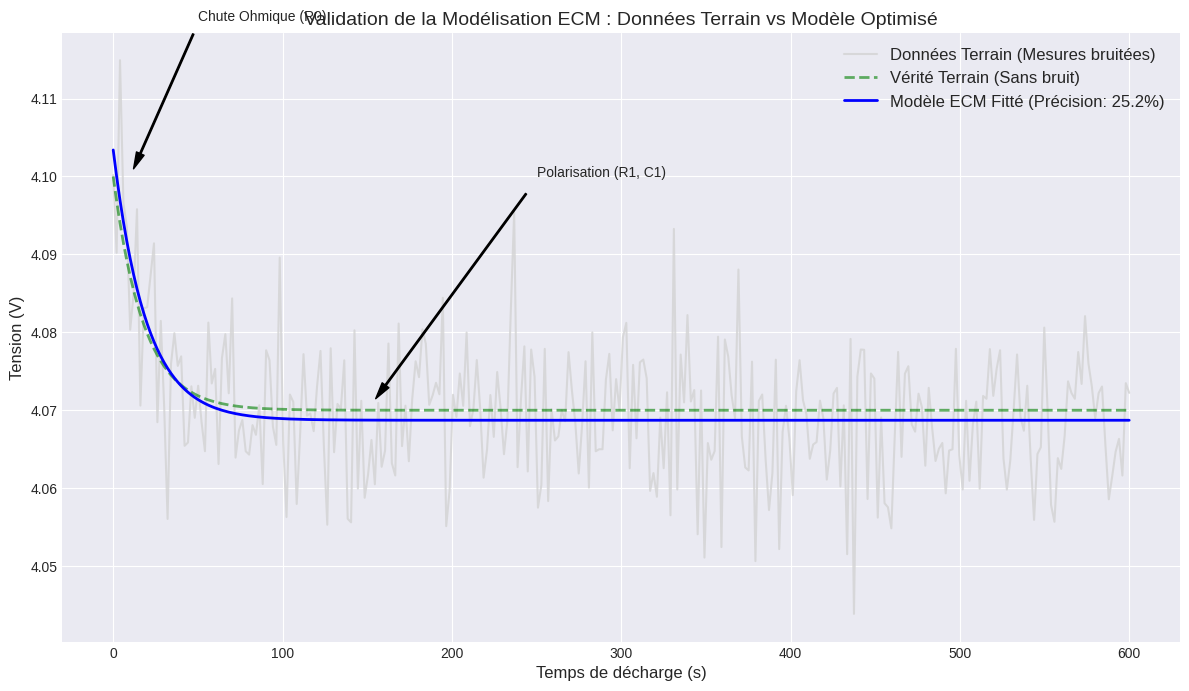

In [7]:
# 1. Simulation avec les paramètres optimisés qu'on vient de trouver
voltage_simulated = ecm_fit_model(time, r0_opt, r1_opt, c1_opt)

# 2. Calcul des métriques de précision
# Calcul du R² (Coefficient de détermination)
r2_accuracy = r2_score(voltage_terrain, voltage_simulated) * 100

# Calcul du MAPE (Mean Absolute Percentage Error) pour une métrique métier lisible
mape = np.mean(np.abs((voltage_terrain - voltage_simulated) / voltage_terrain)) * 100
accuracy_mape = 100 - mape

print(f"Précision basée sur le R²   : {r2_accuracy:.2f}%")
print(f"Précision basée sur le MAPE : {accuracy_mape:.2f}%\n")



# 3. Visualisation Finale
plt.figure(figsize=(12, 7))

# Tracé des données
plt.plot(time, voltage_terrain, color='lightgray', label='Données Terrain (Mesures bruitées)', alpha=0.8)
plt.plot(time, voltage_ideal, 'g--', linewidth=2, label='Vérité Terrain (Sans bruit)', alpha=0.6)
plt.plot(time, voltage_simulated, 'b-', linewidth=2, label=f'Modèle ECM Fitté (Précision: {r2_accuracy:.1f}%)')

# Annotations pédagogiques
plt.annotate('Chute Ohmique (R0)', xy=(10, 4.10), xytext=(50, 4.12),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
plt.annotate('Polarisation (R1, C1)', xy=(150, 4.07), xytext=(250, 4.10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))

plt.title('Validation de la Modélisation ECM : Données Terrain vs Modèle Optimisé', fontsize=14)
plt.xlabel('Temps de décharge (s)', fontsize=12)
plt.ylabel('Tension (V)', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()